# Taller 5

Juan Daniel Torres (201414896)

Orianna Sanguino Gómez (201413158)

## VESÍCULA 

In [1]:
import scipy
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
import cv2
import sys
from scipy.ndimage import label 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


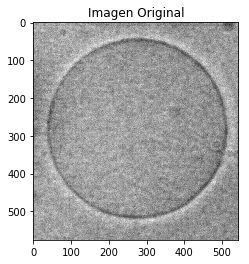

In [3]:
Im1 = pylab.imread("ves_full_150_002.jpg")
pylab.imshow(Im1, cmap = cm.Greys_r)
plt.title('Imagen Original', fontsize=12)
plt.show()

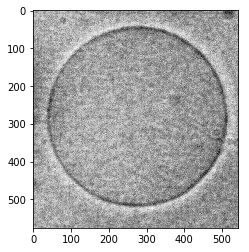

In [4]:
bn = color.rgb2gray(Im1)
pylab.imshow(bn,cmap=cm.Greys_r)
plt.show()

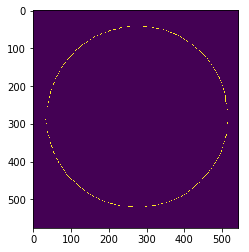

In [5]:
filtro = feature.canny(bn,sigma=3.52)
plt.imshow(filtro)
plt.show()

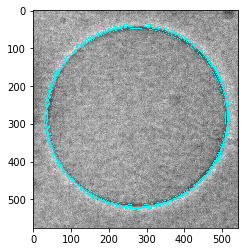

In [6]:
hough_radii = np.arange(200, 260, 2)
hough_res = hough_circle(filtro, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image= color.gray2rgb(bn)

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (0,265,265)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

Ahora se encontrará el diametro de la vesicula

In [7]:
def promedio(valores):
    sumaParcial=0
    for valor in valores:
        sumaParcial+=valor
    cantidadValores = len(valores)
    return sumaParcial/float(cantidadValores)
print(promedio(radii))

239.6


In [8]:
diametro_vesicula= 2*239.6
diametro_vesicula

479.2

Finalmente, se haya la posición del centroide de la vesicula

In [9]:
print(promedio(cx),promedio(cy))

274.8 280.9


## GRANULOMETRÍA

# Ejemplo 1 (monedas)

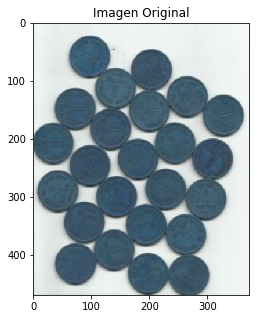

In [10]:
img = cv2.imread("Monedas.PNG")
figure(figsize=(5,5))
pylab.imshow(img, cmap = cm.Greys_r)
plt.title('Imagen Original', fontsize=12)
plt.show()

In [11]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

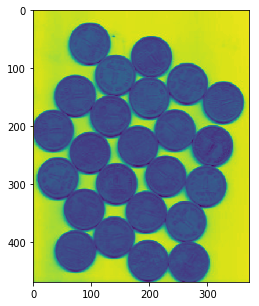

In [12]:
figure(figsize=(5,5))
plt.imshow(gray)
plt.show()

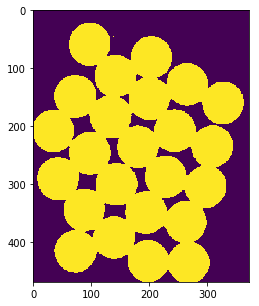

In [13]:
figure(figsize=(5,5))
plt.imshow(thresh)
plt.show()

In [14]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

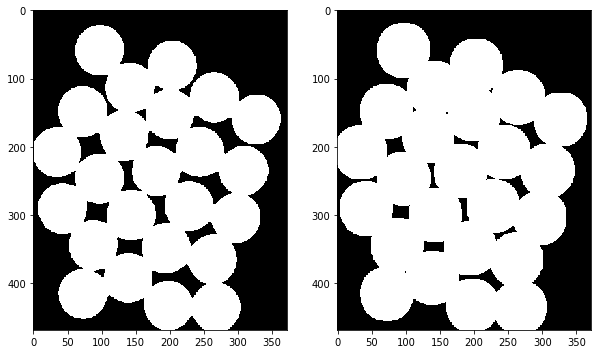

In [15]:
figure(figsize=(10,10))
subplot(1,2,1)
plt.imshow(opening)
pylab.gray()

subplot(1,2,2)
plt.imshow(sure_bg)
pylab.gray()

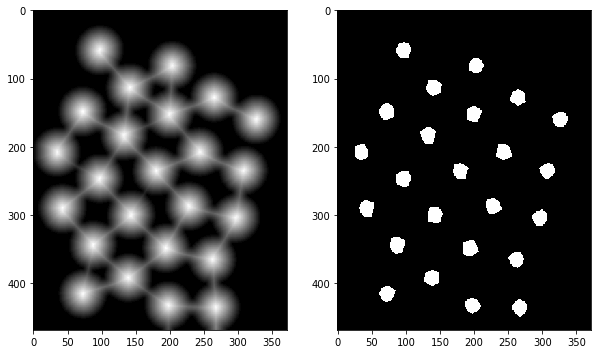

In [16]:
figure(figsize=(10,10))
subplot(1,2,1)
plt.imshow(dist_transform)
pylab.gray()

subplot(1,2,2)
plt.imshow(sure_fg)
pylab.gray()

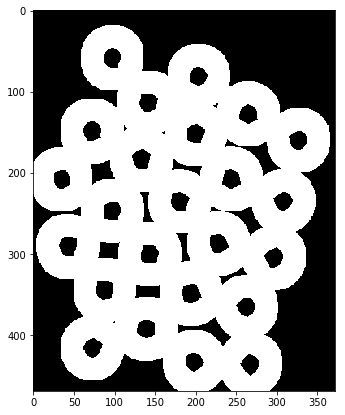

In [17]:
figure(figsize=(7,7))
plt.imshow(unknown)
plt.show()

In [18]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

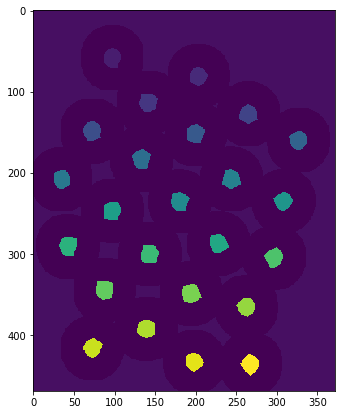

In [19]:
figure(figsize=(7,7))
plt.imshow(markers, cmap= cm.viridis)
plt.show()

In [20]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

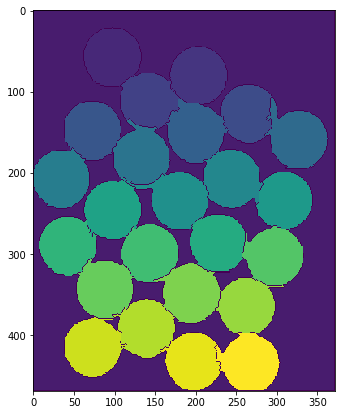

In [21]:
figure(figsize=(7,7))
plt.imshow(markers,cmap= cm.viridis)
plt.show()

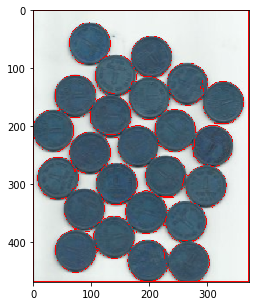

In [22]:
figure(figsize=(5,5))
plt.imshow(img, cmap = cm.Greys_r)
plt.show()

# Ejemplo 2 (pastillas)

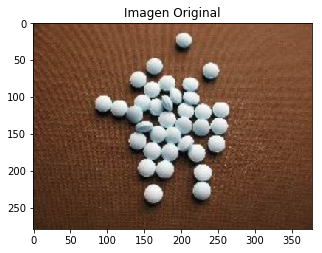

In [23]:
Im1 = cv2.imread("pastillas.PNG")
figure(figsize=(5,5))
pylab.imshow(Im1, cmap = cm.Greys_r)
plt.title('Imagen Original', fontsize=12)
plt.show()

In [24]:
gray = cv2.cvtColor(Im1,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

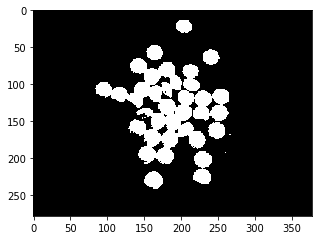

In [25]:
figure(figsize=(5,5))
plt.imshow(thresh)
plt.show()

In [26]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

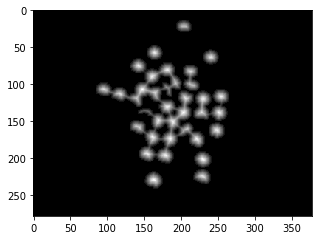

In [27]:
figure(figsize=(5,5))
plt.imshow(dist_transform)
plt.show()

In [28]:
def segment_on_dt(a, img):
    border = cv2.dilate(img, None, iterations=5)
    border = border - cv2.erode(border, None)

    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(numpy.uint8)
    _, dt = cv2.threshold(dt, 180, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    # Completing the markers now. 
    lbl[border == 255] = 255

    lbl = lbl.astype(numpy.int32)
    cv2.watershed(a, lbl)

    lbl[lbl == -1] = 0
    lbl = lbl.astype(numpy.uint8)
    return 255 - lbl

# Pre-processing.
Im1 = cv2.imread("pastillas.PNG")
Im1_gray = cv2.cvtColor(Im1, cv2.COLOR_BGR2GRAY)    
_, Im1_bin = cv2.threshold(Im1_gray, 0, 255,
        cv2.THRESH_OTSU)
Im1_bin = cv2.morphologyEx(Im1_bin, cv2.MORPH_OPEN,
        numpy.ones((3, 3), dtype=int))

result = segment_on_dt(Im1, Im1_bin)
cv2.imwrite('salida.bmp', result)

result[result != 255] = 0
result = cv2.dilate(result, None)
Im1[result == 255] = (0, 255, 0)
cv2.imwrite('resultado.bmp', Im1)

True

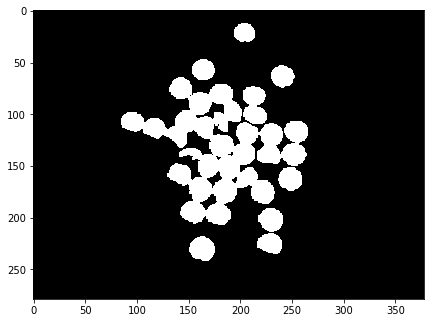

In [29]:
figure(figsize=(7,7))
pylab.imshow(Im1_bin, cmap = cm.Greys_r)
plt.show()

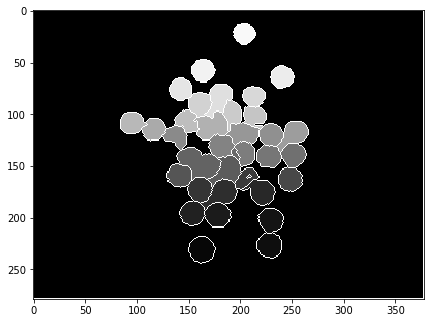

In [30]:
figure(figsize=(7,7))
Imfin = cv2.imread("salida.bmp")
pylab.imshow(Imfin, cmap = cm.Greys_r)
plt.show()

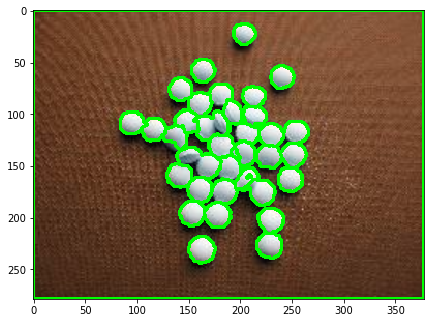

In [31]:
figure(figsize=(7,7))
Result = cv2.imread("resultado.bmp")
pylab.imshow(Result,cmap = cm.Greys_r)
plt.show()

# Metalografía

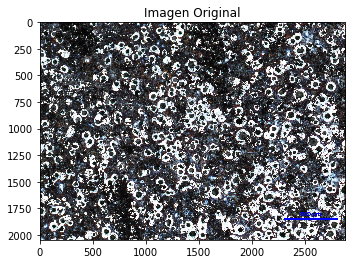

In [32]:
Imgran = cv2.imread("FeNod_50X_L.tif")
gray = cv2.cvtColor(Imgran,cv2.COLOR_BGR2GRAY)
plt.title('Imagen Original', fontsize=12)
pylab.imshow(Imgran, cmap = cm.Greys_r)
plt.show()

In [55]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((4,4),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.05*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

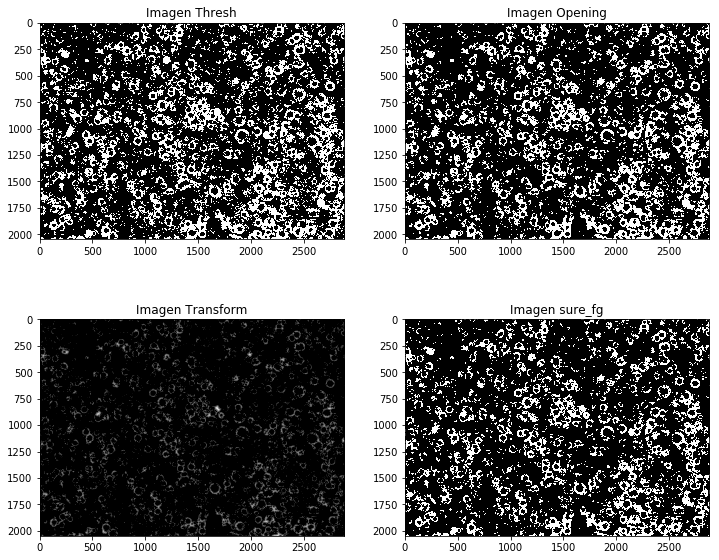

In [56]:
figure(figsize=(12,10))
subplot(2,2,1)
plt.imshow(thresh)
plt.title('Imagen Thresh', fontsize=12)
pylab.gray()

subplot(2,2,2)
plt.imshow(opening)
plt.title('Imagen Opening', fontsize=12)
pylab.gray()

subplot(2,2,3)
plt.imshow(dist_transform)
plt.title('Imagen Transform', fontsize=12)
pylab.gray()

subplot(2,2,4)
plt.imshow(sure_fg)
plt.title('Imagen sure_fg', fontsize=12)
pylab.gray()

In [57]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(Imgran,markers)
Imgran[markers == -1] = [255,0,0]

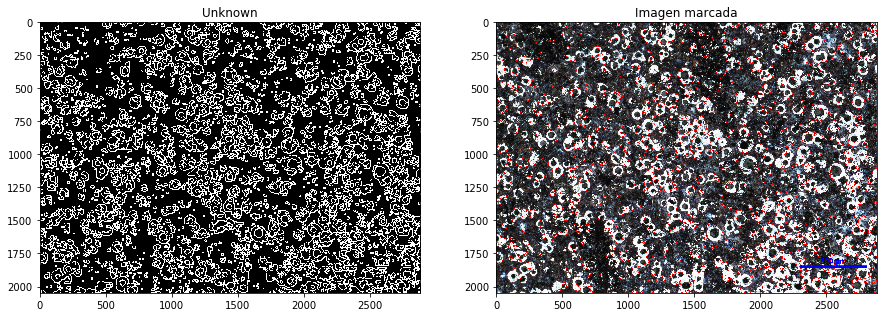

In [58]:
figure(figsize=(15,13))
subplot(1,2,1)
plt.title('Unknown', fontsize=12)
pylab.imshow(unknown)
pylab.gray()

subplot(1,2,2)
plt.title('Imagen marcada', fontsize=12)
pylab.imshow(Imgran)
pylab.gray()

In [ ]:
bn = color.rgb2gray(Imgran)
filtro = feature.canny(bn,sigma=3.5)
plt.imshow(filtro)
plt.show()

In [ ]:
hough_res = hough_circle(filtro,np.arange(50,80,1))
accums, cx, cy, radii = hough_circle_peaks(hough_res, np.arange(50,80,1))